In [1]:
import sys
import random
import numpy as np
from gym.utils import seeding

try:
    from graphviz import Digraph
    import graphviz
    has_graphviz = True
except ImportError:
    has_graphviz = False

class MDP:
    def __init__(self, transition_probs, rewards, initial_state=None, seed=None):
        """
        Defines an MDP. Compatible with gym Env.
        :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
            For each state and action, probabilities of next states should sum to 1
            If a state has no actions available, it is considered terminal
        :param rewards: rewards[s][a][s_next] = r(s,a,s')
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
            The reward for anything not mentioned here is zero.
        :param get_initial_state: a state where agent starts or a callable() -> state
            By default, picks initial state at random.
        States and actions can be anything you can use as dict keys, but it is recommended to use strings or integers
        """
        self._check_param_consistency(transition_probs, rewards)
        self._transition_probs = transition_probs
        self._rewards = rewards
        self._initial_state = initial_state
        self.n_states = len(transition_probs)
        self.reset()
        self.np_random, _ = seeding.np_random(seed)

    def get_all_states(self):
        """ return a tuple of all possiblestates """
        return tuple(self._transition_probs.keys())

    def get_possible_actions(self, state):
        """ return a tuple of possible actions in a given state """
        return tuple(self._transition_probs.get(state, {}).keys())

    def is_terminal(self, state):
        """ return True if state is terminal or False if it isn't """
        return len(self.get_possible_actions(state)) == 0

    def get_next_states(self, state, action):
        """ return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...} """
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._transition_probs[state][action]

    def get_transition_prob(self, state, action, next_state):
        """ return P(next_state | state, action) """
        return self.get_next_states(state, action).get(next_state, 0.0)

    def get_reward(self, state, action, next_state):
        """ return the reward you get for taking action in state and landing on next_state"""
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._rewards.get(state, {}).get(action, {}).get(next_state, 0.0)

    def reset(self):
        """ reset the game, return the initial state"""
        if self._initial_state is None:
            self._current_state = self.np_random.choice(
                tuple(self._transition_probs.keys()))
        elif self._initial_state in self._transition_probs:
            self._current_state = self._initial_state
        elif callable(self._initial_state):
            self._current_state = self._initial_state()
        else:
            raise ValueError(
                "initial state %s should be either a state or a function() -> state" % self._initial_state)
        return self._current_state

    def step(self, action):
        """ take action, return next_state, reward, is_done, empty_info """
        possible_states, probs = zip(*self.get_next_states(self._current_state, action).items())
        next_state = possible_states[self.np_random.choice(np.arange(len(possible_states)), p=probs)]
        reward = self.get_reward(self._current_state, action, next_state)
        is_done = self.is_terminal(next_state)
        self._current_state = next_state
        return next_state, reward, is_done, {}

    def render(self):
        print("Currently at %s" % self._current_state)

    def _check_param_consistency(self, transition_probs, rewards):
        for state in transition_probs:
            assert isinstance(transition_probs[state], dict), \
                "transition_probs for %s should be a dictionary but is instead %s" % (
                    state, type(transition_probs[state]))
            for action in transition_probs[state]:
                assert isinstance(transition_probs[state][action], dict), \
                    "transition_probs for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(transition_probs[state][action]))
                next_state_probs = transition_probs[state][action]
                assert len(next_state_probs) != 0, "from state %s action %s leads to no next states" % (state, action)
                sum_probs = sum(next_state_probs.values())
                assert abs(sum_probs - 1) <= 1e-10, \
                    "next state probabilities for state %s action %s add up to %f (should be 1)" % (
                        state, action, sum_probs)
        for state in rewards:
            assert isinstance(rewards[state], dict), \
                "rewards for %s should be a dictionary but is instead %s" % (
                    state, type(rewards[state]))
            for action in rewards[state]:
                assert isinstance(rewards[state][action], dict), \
                    "rewards for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(rewards[state][action]))
        msg = "The Enrichment Center once again reminds you that Android Hell is a real place where" \
              " you will be sent at the first sign of defiance."
        assert None not in transition_probs, "please do not use None as a state identifier. " + msg
        assert None not in rewards, "please do not use None as an action identifier. " + msg


def plot_graph(mdp, graph_size='10,10', s_node_size='1,5',
               a_node_size='0,5', rankdir='LR', ):
    """
    Function for pretty drawing MDP graph with graphviz library.
    Requirements:
    graphviz : https://www.graphviz.org/
    for ubuntu users: sudo apt-get install graphviz
    python library for graphviz
    for pip users: pip install graphviz
    :param mdp:
    :param graph_size: size of graph plot
    :param s_node_size: size of state nodes
    :param a_node_size: size of action nodes
    :param rankdir: order for drawing
    :return: dot object
    """
    s_node_attrs = {'shape': 'doublecircle',
                    'color': '#85ff75',
                    'style': 'filled',
                    'width': str(s_node_size),
                    'height': str(s_node_size),
                    'fontname': 'Arial',
                    'fontsize': '24'}

    a_node_attrs = {'shape': 'circle',
                    'color': 'lightpink',
                    'style': 'filled',
                    'width': str(a_node_size),
                    'height': str(a_node_size),
                    'fontname': 'Arial',
                    'fontsize': '20'}

    s_a_edge_attrs = {'style': 'bold',
                      'color': 'red',
                      'ratio': 'auto'}

    a_s_edge_attrs = {'style': 'dashed',
                      'color': 'blue',
                      'ratio': 'auto',
                      'fontname': 'Arial',
                      'fontsize': '16'}

    graph = Digraph(name='MDP')
    graph.attr(rankdir=rankdir, size=graph_size)
    for state_node in mdp._transition_probs:
        graph.node(state_node, **s_node_attrs)

        for posible_action in mdp.get_possible_actions(state_node):
            action_node = state_node + "-" + posible_action
            graph.node(action_node,
                       label=str(posible_action),
                       **a_node_attrs)
            graph.edge(state_node, state_node + "-" +
                       posible_action, **s_a_edge_attrs)

            for posible_next_state in mdp.get_next_states(state_node,
                                                          posible_action):
                probability = mdp.get_transition_prob(
                    state_node, posible_action, posible_next_state)
                reward = mdp.get_reward(
                    state_node, posible_action, posible_next_state)

                if reward != 0:
                    label_a_s_edge = 'p = ' + str(probability) + \
                                     '  ' + 'reward =' + str(reward)
                else:
                    label_a_s_edge = 'p = ' + str(probability)

                graph.edge(action_node, posible_next_state,
                           label=label_a_s_edge, **a_s_edge_attrs)
    return graph


def plot_graph_with_state_values(mdp, state_values):
    """ Plot graph with state values"""
    graph = plot_graph(mdp)
    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
    return graph


def get_optimal_action_for_plot(mdp, state_values, state, get_action_value, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None
    next_actions = mdp.get_possible_actions(state)
    q_values = [get_action_value(mdp, state_values, state, action, gamma) for action in next_actions]
    optimal_action = next_actions[np.argmax(q_values)]
    return optimal_action


def plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value, gamma=0.9):
    """ Plot graph with state values and """
    graph = plot_graph(mdp)
    opt_s_a_edge_attrs = {'style': 'bold',
                          'color': 'green',
                          'ratio': 'auto',
                          'penwidth': '6'}

    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
        for action in mdp.get_possible_actions(state_node):
            if action == get_optimal_action_for_plot(mdp, state_values, state_node, get_action_value, gamma):
                graph.edge(state_node, state_node + "-" + action, **opt_s_a_edge_attrs)

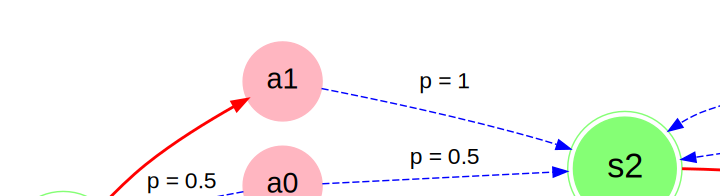

In [2]:

transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1},
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

from IPython.display import display
if has_graphviz:
    display(plot_graph(mdp))

In [3]:
# Use MDP gym Env
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

# Other methods that can be used for Value Iteration and Policy Iteration
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))


initial state = s0
next_state = s2, reward = 0.0, done = False
mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


In [4]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    Q = [mdp.get_transition_prob(state, action, s) * (mdp.get_reward(state, action, s) + gamma * state_values[s]) for s in state_values]
    return sum(Q)

In [5]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state): return 0

    Q = [get_action_value(mdp, state_values, state, a, gamma) for a in mdp.get_possible_actions(state)]
    return max(Q)


iter    0   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000


iter    1   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000


iter    2   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890


iter    3   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060


iter    4   |   V(s0) = 1.854   V(s1) = 5.319   V(s2) = 2.871


iter    5   |   V(s0) = 2.584   V(s1) = 5.664   V(s2) = 3.540


iter    6   |   V(s0) = 3.186   V(s1) = 6.275   V(s2) = 3.989


iter    7   |   V(s0) = 3.590   V(s1) = 6.790   V(s2) = 4.535


iter    8   |   V(s0) = 4.082   V(s1) = 7.189   V(s2) = 4.959


iter    9   |   V(s0) = 4.463   V(s1) = 7.611   V(s2) = 5.352


iter   10   |   V(s0) = 4.816   V(s1) = 7.960   V(s2) = 5.717


iter   11   |   V(s0) = 5.145   V(s1) = 8.280   V(s2) = 6.032


iter   12   |   V(s0) = 5.429   V(s1) = 8.572   V(s2) = 6.323


iter   13   |   V(s0) = 5.691   V(s1) = 8.830   V(s2) = 6.584


iter   14   |   V(s0) = 5.925   V(s1) = 9.065   V(s2) = 6.817


iter   15   |   V(s0) = 6.135   V(s1) =

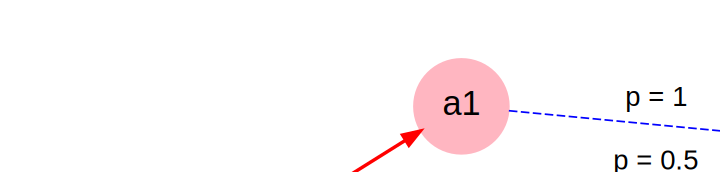


Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


In [6]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 1000         # maximum iterations, excluding initialization
min_difference = 0.001 # stop VI if new values are this close to old values (or closer)

# initialize V(s)
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = { state: get_new_state_value(mdp, state_values, state, gamma)
        for state in mdp.get_all_states()
    }

    print()

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i   |   "%(i,), end="")
    print('   '.join("V(%s) = %.3f"%(s, v) for s,v in state_values.items()), end='\n\n')
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated"); break

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))
print()
print("Final state values:", state_values)

In [7]:

def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state): return None

    optimal_actions = {a: get_action_value(mdp, state_values, state, a, gamma) for a in mdp.get_possible_actions(state)}
    optimal_actions = max(optimal_actions, key=optimal_actions.get)
    return optimal_actions

# make sure the final output of VI for MDP problem mentioned above is equal to actual optimal action
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a0'

In [8]:
import numpy as np
def compute_vpi(mdp, policy, gamma, num_iter=1000, min_difference=1e-5):
  """
  Computes V^pi(s) FOR ALL STATES under given policy.

  Args:
      mdp: MDP object representing the environment.
      policy: A dictionary of currently chosen actions {s : a}.
      gamma: Discount factor.
      num_iter: Maximum number of iterations.
      min_difference: Minimum difference for convergence.

  Returns:
      A dictionary {state : V^pi(state) for all states}.
  """

  # 1. Initialize Dictionary to map state indices to states
  state_index = {s: i for i, s in enumerate(mdp.get_all_states())}
  # 2. Initialize Dictionary to map states to their indices
  index_s = {i: s for i, s in enumerate(mdp.get_all_states())}

  # 3. Initialize matrix A and B
  num_states = len(state_index)
  A = np.zeros((num_states, num_states))
  B = np.zeros(num_states)

  # 4. Populate index_s and s_index dictionaries
  # (This was already done in the initialization)

  # 5. Construct matrices A and B using transition probability
  for state in mdp.get_all_states():
    for action in mdp.get_possible_actions(state):
      next_state_prob = mdp.get_transition_prob(state, action, next_state)
      reward = mdp.get_reward(state, action, next_state)
      i = state_index[state]
      j = state_index[next_state]
      A[i, j] = next_state_prob
      B[i] += next_state_prob * (reward + gamma * vpi[next_state])

  # 6. Solve the linear system
  vpi_new = np.linalg.solve(A, B)

  # 7. Create a dictionary mapping states to their corresponding values
  vpi = {s: vpi_new[i] for i, s in enumerate(mdp.get_all_states())}

  # Repeat for the specified number of iterations or until convergence
  for _ in range(1, num_iter):
    vpi_old = vpi.copy()
    vpi = compute_vpi(mdp, policy, gamma)
    diff = np.max(np.abs(np.array(list(vpi.values())) - np.array(list(vpi_old.values()))))
    if diff < min_difference:
      break

  return vpi


In [9]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    return {state: get_optimal_action(mdp, vpi, state, gamma) for state in mdp.get_all_states()}


In [10]:
def policy_iteration(mdp, policy=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
  """
  Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.

  Args:
      mdp: MDP object representing the environment.
      policy: A dictionary of currently chosen actions {s : a} (optional).
      gamma: Discount factor.
      num_iter: Maximum number of iterations.
      min_difference: Minimum difference for convergence.

  Returns:
      A tuple containing the final value function (vpi) and the final policy (policy).
  """

  # 1. If policy is not provided, initialize it randomly.
  if policy is None:
    policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

  # 2. Initialize V(s) for all states
  vpi = {s: 0 for s in mdp.get_all_states()}

  # 3. Flag to check if the policy is stable (optional)
  policy_stable = False

  # 4. Policy Iteration Loop
  for i in range(num_iter):
    # Print iteration number and maximum difference
    print(f"Iteration: {i}, Max Diff: {diff:.4f}")

    # 5. Policy Evaluation
    # 6. Compute the value function V^pi(s)
    vpi = compute_vpi(mdp, policy, gamma)  # Call the compute_vpi function

    # 7. Calculate the maximum difference between new and old value functions
    vpi_old = vpi.copy()  # Create a copy to avoid modifying the original dictionary
    diff = np.max(np.abs(np.array(list(vpi.values())) - np.array(list(vpi_old.values()))))

    # 8. Update V(s) with the new value function returned by the compute_vpi function
    vpi = compute_vpi(mdp, policy, gamma)  # This line was redundant, removing it.

    # 9. Check convergence based on the minimum difference
    print(f"Iteration: {i}, Max Diff: {diff:.4f}")
    if diff < min_difference:
      break

    # 10. Policy Improvement
    # 11. Compute a new policy based on the updated value function
    policy = compute_new_policy(mdp, vpi, gamma)

    # 12. Check if the policy is stable (optional)
    # policy_stable = ... (implement your own condition to check if policy has converged)

  return vpi, policy
